# Matrix Factorization using Bregman Divergenses

## Testing NMF class

In [114]:
from sklearn.decomposition import NMF as nmfsk
from MatrixFactorization import NMF as nmfmy
from MatrixFactorization import myNMF as nmfmycomb

import numpy as np
from numpy.random import RandomState
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.metrics import explained_variance_score



## 1. Gaussian Distribution Graphs

### 1.1 Selecting best way to represent Gaussian Distribution with Non- negative Values

Gaussian Distribution from definition varies from negative infinity to positive infinity. Since NMF requires data with non-negative values this causes problems. To handle this i examine two different approaches for having data with non-negative values that approach a normal distribution.

#### 1.1a Take the absolute value

First i try taking the abolute value of all data from a normal distribution. The results as shown by the graph below where near a normal distribution but at the left of the mean the result was not encouraged.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
rs = RandomState(76321654)
V = rs.normal(4,3.14,10000).reshape(200,50)
V = np.abs(V)
sns.set(color_codes=True)
sns.distplot(V[4])

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [3]:
V.mean()

4.303987512332083

In [4]:
V.std()

2.741339454329155

#### 1.1b Add the absolute of the MIN

The other approach was adding the absolute of the min value. This ensures that all values will be non-negative and also it tries to keep the distribution as it was by shifting the data to the right.

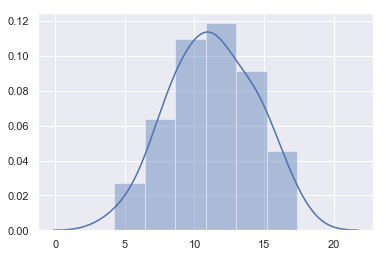

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
rs = RandomState(76321654)
V = rs.normal(5,3.14,10000).reshape(200,50)
V = np.add(V,abs(np.min(V)))
sns.set(color_codes=True)
sns.distplot(V[4])


As can be seen from the above graphs the second way provides better approximation of a normal distribution with non-negative values. Thus the second approach will be used throughout for producing non-negative data resampling normal distribution. 

In [6]:
V.mean()


11.620873774806372

In [7]:
V.std()

3.1572744919693414

In [8]:
def normal_positive_data_add_min(rows, columns, mean, std):
    
    rs = RandomState(76321654)
    V = rs.normal(mean,std,rows * columns).reshape(rows,columns)
    V = np.add(V,abs(np.min(V)))
    return V

In [9]:
def normal_positive_data_abs(rows, columns, mean, std):
    
    rs = RandomState(76321654)
    V = rs.normal(mean,std,rows * columns).reshape(rows,columns)
    V = np.abs(V)

    return V

### 1.2 Test NMF for Data coming from Normal Distribution

In [10]:
V = normal_positive_data_add_min(rows = 2000 , columns = 150, mean=5, std=3.14)
n = 20

#### LOG Likelihood as taken from http://mikkelschmidt.dk/presentations/nmfgppcam.pdf

In [11]:
import math
def neg_log_likelihood_normal(V,W,H):
    st = np.std(V)
    const = V.shape[0] * V.shape[1] * np.log((2*math.pi)**2 *st)
    lpart = np.sum( (V - W.dot(H))**2  / (2* st**2) )
    l = const + lpart
    return l

### Compare Different Initializations

In [127]:
def plot_error_graphs(erros_measure,errors,labels,mean,std,title):

   
    
    
    fig_1 = plt.figure(figsize=(10, 10))
    ax_1 = fig_1.add_subplot(111)

    
    for (error,label) in zip(errors,labels):
    
        ax_1.plot(np.arange(1,error.shape[0]+1), 
                  error, label= label, linewidth=3)
        

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'


    #plt.tight_layout()
    ax_1.set_xlabel('N components')
    ax_1.set_ylabel(erros_measure)
    ax_1.set_title(erros_measure +' for Gaussian Distribution with mean = ' + str("%.3f" % round(mean,3))+ ' and std = ' + str("%.3f" % round(std,3)), fontsize = 30)
    fig_1.tight_layout(pad=0)
    fig_1.savefig('GaussianGraphsDiss/Normal' + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf')



In [51]:
from collections import OrderedDict  
linestyles = OrderedDict(
    [
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     #('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     #('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     #('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     #('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ])
    
linestyles.values()

odict_values([(0, (1, 10)), (0, (1, 5)), (0, (5, 10)), (0, (5, 5)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5)), (0, (3, 10, 1, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5))])

In [180]:
def plot_error_graphs_dashed(erros_measure,errors,labels,mean,std,title):

   
    formats = ["D","X","H","o","s","^","v","2"]
    linestyles = OrderedDict(
    [
     #('loosely dotted',      (0, (1, 10))),
     #('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     #('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ])
    
    i = 0
    linestyles_ =  list(linestyles.values())
    
    fig_1 = plt.figure(figsize=(16, 10))
    ax_1 = fig_1.add_subplot(111)

    
    for (error,label) in zip(errors,labels):
        
        c = i % len(linestyles_)
        ax_1.plot(np.arange(1,error.shape[0]+1), 
                  error, marker=formats[i],linestyle =linestyles_[c], markersize=5.5,label= label, linewidth=3.5)
        i += 1

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'

    
    erros_measure_labels = {'Mean Squared Error' : 'MSQ',
                            'Mean Absolute Error': 'MAB',
                            'Average Negative LogLikelihood' : 'ANLL',
                            'Explained Variance' : 'Explained Variance',
                            'Time' : 'Time'
                           }

    #plt.tight_layout()
    plt.xscale("linear")
    ax_1.set_xlabel('Number of Components')
    ax_1.set_ylabel(erros_measure)
    ax_1.set_title(erros_measure_labels[erros_measure] +' between V (gaussian) and V\' ' , fontsize = 30)
    fig_1.tight_layout(pad=0)
    fig_1.savefig('InitGraphs/' + erros_measure + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf',  bbox_inches='tight')



In [71]:
def plot_error_graphs_dotted(erros_measure,errors,labels,mean,std,title):

   
    formats = ["D","X","H","s","^","o","v","2"]
    i = 0
   
    fig_1 = plt.figure(figsize=(16, 16))
    ax_1 = fig_1.add_subplot(111)

    
    for (error,label) in zip(errors,labels):
        

        ax_1.plot(np.arange(1,error.shape[0]+1), 
                  error, formats[i]+':', markersize=5.2,label= label, linewidth=3.20)
        i += 1

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'


    #plt.tight_layout()
    ax_1.set_xlabel('N components')
    ax_1.set_ylabel(erros_measure)
    ax_1.set_title(erros_measure +' for Gaussian Distribution with mean = ' + str("%.3f" % round(mean,3))+ ' and std = ' + str("%.3f" % round(std,3)), fontsize = 30)
    fig_1.tight_layout(pad=0)
    fig_1.savefig('GaussianGraphsDiss/Normal' + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf')




In [75]:
def plot_error_graphs_dotted_no_mark(erros_measure,errors,labels,mean,std,title):

   
    formats = ["D","X","H","s","^","o","v","2"]
    i = 0
   
    fig_1 = plt.figure(figsize=(16, 16))
    ax_1 = fig_1.add_subplot(111)

    
    for (error,label) in zip(errors,labels):
        
        
        ax_1.plot(np.arange(1,error.shape[0]+1), 
                  error, ':', markersize=7,label= label, linewidth=3.20)
        i += 1

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'


    #plt.tight_layout()
    ax_1.set_xlabel('N components')
    ax_1.set_ylabel(erros_measure)
    ax_1.set_title(erros_measure +' for Gaussian Distribution with mean = ' + str("%.3f" % round(mean,3))+ ' and std = ' + str("%.3f" % round(std,3)), fontsize = 30)
    fig_1.tight_layout(pad=0)
    fig_1.savefig('GaussianGraphsDiss/Normal' + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf')





In [18]:
def plot_error_graphs_no_marker(erros_measure,errors,labels,mean,std,title):

   
    formats = ["D","X","H","s","^","o","v","2"]
    i = 0
   
    fig_1 = plt.figure(figsize=(16, 16))
    ax_1 = fig_1.add_subplot(111)

    
    for (error,label) in zip(errors,labels):
        
        
        ax_1.plot(np.arange(1,error.shape[0]+1), 
                  error, '--', markersize=6,label= label, linewidth=3.20)
        i += 1

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'


    #plt.tight_layout()
    ax_1.set_xlabel('number of components components')
    ax_1.set_ylabel(erros_measure)
    ax_1.set_title(erros_measure +' for Gaussian Distribution with mean = ' + str("%.3f" % round(mean,3))+ ' and std = ' + str("%.3f" % round(std,3)), fontsize = 30)
    fig_1.tight_layout(pad=0)
    fig_1.savefig('GaussianGraphsDiss/Normal' + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf')



In [19]:
def plot_error_graphs_norm(erros_measure,errors,labels,mean,std,title,change_title=None):

   
    
    errors = normalize(errors, norm='max', axis=0, copy=True, return_norm=False)

    fig_1 = plt.figure(figsize=(16, 10))
    ax_1 = fig_1.add_subplot(111)

    #min_ = np.min(errors)
    #max_ = np.max(errors)
    #print(min_)
    #print(max_)
    #ax_1.set_autoscaley_on(False)
    
    for (error,label) in zip(errors,labels):
    
        ax_1.plot(np.arange(1,error.shape[0]+1), error,
                   label= label, linewidth=3)
        

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    #ax_1.set_yscale('logit')
    #autoscale_x(ax_1)

    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'
    #scale.register_scale(scale.InvertedLogTransformBase(shorthand_name='ilt'))
    #plt.gca().set_xscale('log', basey=1.5)
    #plt.yticks([0.02,0.03,0.04,0.05,0.1],['0.02','0.03','0.04','0.05','0.1'])
    #plt.xticks([0,10,50])
    #xbounds = ax_1.get_xlim()
    #et(gca, 'xtick', xbounds(1):0.1:xbounds(2))
    #plt.xlim([1, 50])
    #plt.xticks(np.logspace(start=0,stop=5, num=5,base=2))
    #plt.tight_layout()
    ax_1.set_xlabel('number of components')
    ax_1.set_ylabel(erros_measure)
    ax_1.set_title(erros_measure +'Gaussian Distribution mean = ' + str("%.3f" % round(mean,3))+ ' and std = ' + str("%.3f" % round(std,3)), fontsize = 30)
    fig_1.tight_layout(pad=0)
    if change_title :
        fig_1.savefig('GaussianGraphsDiss/' + change_title +'.pdf')
    else:
        fig_1.savefig('GaussianGraphsDiss/Normal' + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf')



In [118]:
V = normal_positive_data_add_min(rows = 10000 , columns = 100, mean=12, std=5.15)
import time

initialization = ['random','random scaled', 'nndsvd', 'nndsvda', 'nndsvdar']
mab_random = np.zeros(100)
mab_random_scaled= np.zeros(100)
mab_nndsvd = np.zeros(100)
mab_nndsvda = np.zeros(100)
mab_nndsvdar = np.zeros(100)

msq_random = np.zeros(100)
msq_random_scaled= np.zeros(100)
msq_nndsvd = np.zeros(100)
msq_nndsvda = np.zeros(100)
msq_nndsvdar = np.zeros(100)
                       
anl_random = np.zeros(100)
anl_random_scaled= np.zeros(100)
anl_nndsvd = np.zeros(100)
anl_nndsvda = np.zeros(100)
anl_nndsvdar = np.zeros(100)

explained_var_ran = np.zeros(100)
explained_var_ran_scale = np.zeros(100)
explained_var_nndsvd = np.zeros(100)
explained_var_nndsvda = np.zeros(100)
explained_var_nndsvdar = np.zeros(100)

time_ran = np.zeros(100)
time_ran_scale = np.zeros(100)
time_nndsvd = np.zeros(100)
time_nndsvda = np.zeros(100)
time_nndsvdar = np.zeros(100)



max_it = 200
for n in range(1, 101):
    print(n)
    rs = RandomState(76321654)
    
        
    #My Random
    rs = RandomState(76321654)
    start = time.clock()
    nmfM = nmfmy(n_components=n,random_state=rs,init=None, distribution='gaussian',max_iterations=max_it)
    Wran, Hran = nmfM.fit_transform(V)
    V_ran = Wran.dot(Hran)
    time_ran[n-1] = time.clock() - start
    
    #Scale Random
    rs = RandomState(76321654)
    start = time.clock()
    nmfM = nmfmy(n_components=n,random_state=rs,init='random', distribution='gaussian',max_iterations=max_it)
    Wran_s, Hran_s = nmfM.fit_transform(V)
    V_ran_s = Wran_s.dot(Hran_s)
    time_ran_scale[n-1] = time.clock() - start
    
    #NNDSVD
    rs = RandomState(76321654)
    start = time.clock()
    nmfM = nmfmy(n_components=n,random_state=rs,init='nndsvd', distribution='gaussian', max_iterations=max_it)
    Wnndsvd, Hnndsvd = nmfM.fit_transform(V)
    V_nndsvd = Wnndsvd.dot(Hnndsvd)
    time_nndsvd[n-1] = time.clock() - start
    
    #NNDSVDA
    rs = RandomState(76321654)
    start = time.clock()
    nmfM = nmfmy(n_components=n,random_state=rs,init='nndsvda', distribution='gaussian', max_iterations=max_it)
    Wnndsvda, Hnndsvda = nmfM.fit_transform(V)
    V_nndsvda = Wnndsvda.dot(Hnndsvda)
    time_nndsvda[n-1] = time.clock() - start

    
    #NNDSVDAR
    rs = RandomState(76321654)
    start = time.clock()
    nmfM = nmfmy(n_components=n,random_state=rs,init='nndsvdar', distribution='gaussian', max_iterations=max_it)
    Wnndsvdar, Hnndsvdar = nmfM.fit_transform(V)
    V_nndsvdar = Wnndsvdar.dot(Hnndsvdar)
    time_nndsvda[n-1] = time.clock() - start

 
    
    # Mean Absolute Value
    mab_random[n-1] = mean_absolute_error(V,V_ran)
    mab_random_scaled[n-1] = mean_absolute_error(V,V_ran_s)
    mab_nndsvd[n-1] = mean_absolute_error(V,V_nndsvd)
    mab_nndsvda[n-1] = mean_absolute_error(V,V_nndsvda)
    mab_nndsvdar[n-1] = mean_absolute_error(V,V_nndsvdar)




    
    # Mean Squared Errors 
    msq_random[n-1] = mean_squared_error(V,V_ran)
    msq_random_scaled[n-1] = mean_squared_error(V,V_ran_s)
    msq_nndsvd[n-1] = mean_squared_error(V,V_nndsvd)
    msq_nndsvda[n-1] = mean_squared_error(V,V_nndsvda)
    msq_nndsvdar[n-1] = mean_squared_error(V,V_nndsvdar)


    # Average Neg Log Likelihoods
  
    diffran = neg_log_likelihood_normal(V, Wran, Hran)
    anl_random[n-1] = diffran / (V.shape[0] * V.shape[1])
    
    diffranscaled = neg_log_likelihood_normal(V, Wran_s, Hran_s)
    anl_random_scaled[n-1] = diffranscaled / (V.shape[0] * V.shape[1])
    
    diffnndsvd = neg_log_likelihood_normal(V, Wnndsvd, Hnndsvd)
    anl_nndsvd[n-1] = diffnndsvd / (V.shape[0] * V.shape[1])

    diffnndsvda = neg_log_likelihood_normal(V, Wnndsvda, Hnndsvda)
    anl_nndsvda[n-1] = diffnndsvda / (V.shape[0] * V.shape[1])

    diffnndsvdar = neg_log_likelihood_normal(V, Wnndsvdar, Hnndsvdar)
    anl_nndsvdar[n-1] = diffnndsvdar / (V.shape[0] * V.shape[1])
    
    
    # Explained Variance
    explained_var_ran[n-1] = explained_variance_score(V,V_ran)
    explained_var_ran_scale[n-1] = explained_variance_score(V,V_ran_s)
    explained_var_nndsvd[n-1] = explained_variance_score(V,V_nndsvd)
    explained_var_nndsvda[n-1] = explained_variance_score(V,V_nndsvda)
    explained_var_nndsvdar[n-1] = explained_variance_score(V,V_nndsvdar)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [119]:
explained_variance_score(V, V_nndsvdar)

0.8209245732691981

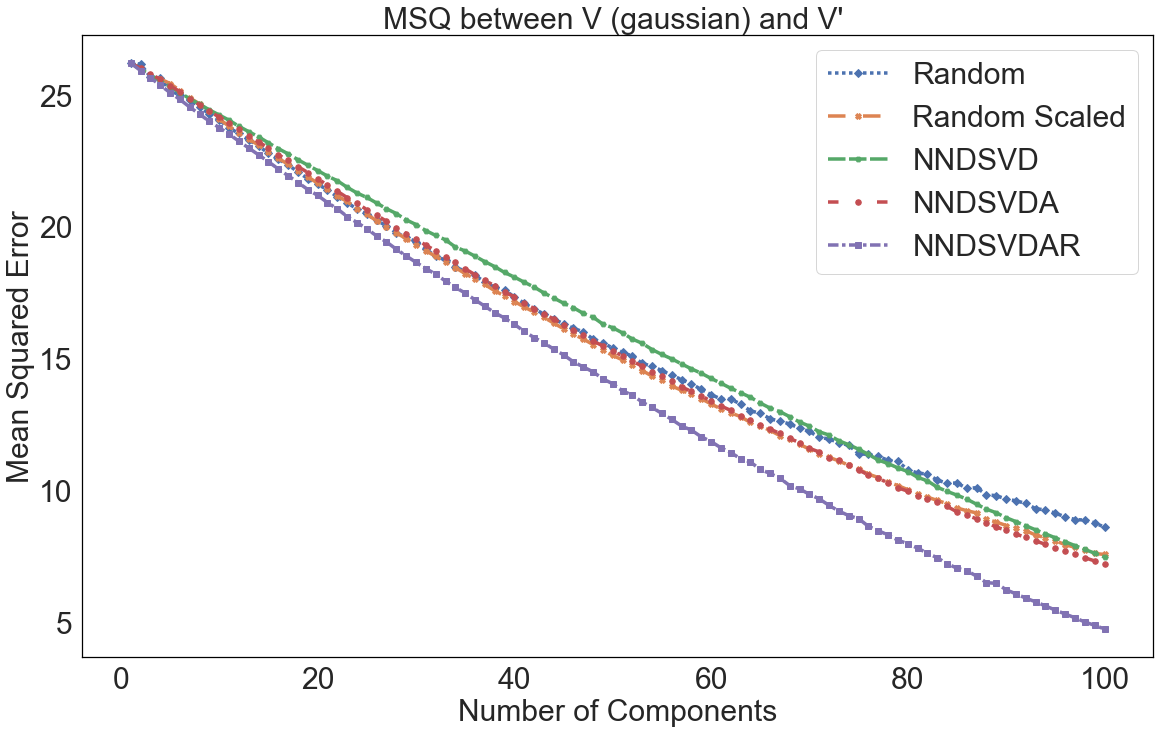

In [169]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
#scale.register_scale(InvertedSymmetricalLogScale)
from sklearn.preprocessing import scale, MinMaxScaler

plot_error_graphs_dashed('Mean Squared Error',  [msq_random,msq_random_scaled,msq_nndsvd,msq_nndsvda,msq_nndsvdar],['Random','Random Scaled','NNDSVD','NNDSVDA','NNDSVDAR'],V.mean(),V.std(),'CheckDifferentInitializationsMSQ')
#plot_error_graphs('MSE',  [msq_gauss,msq_pois],['Gaussian Rules','Poisson Rules'],V.mean(),V.std(),'MSQtestSmoothness1000iter2000columns')

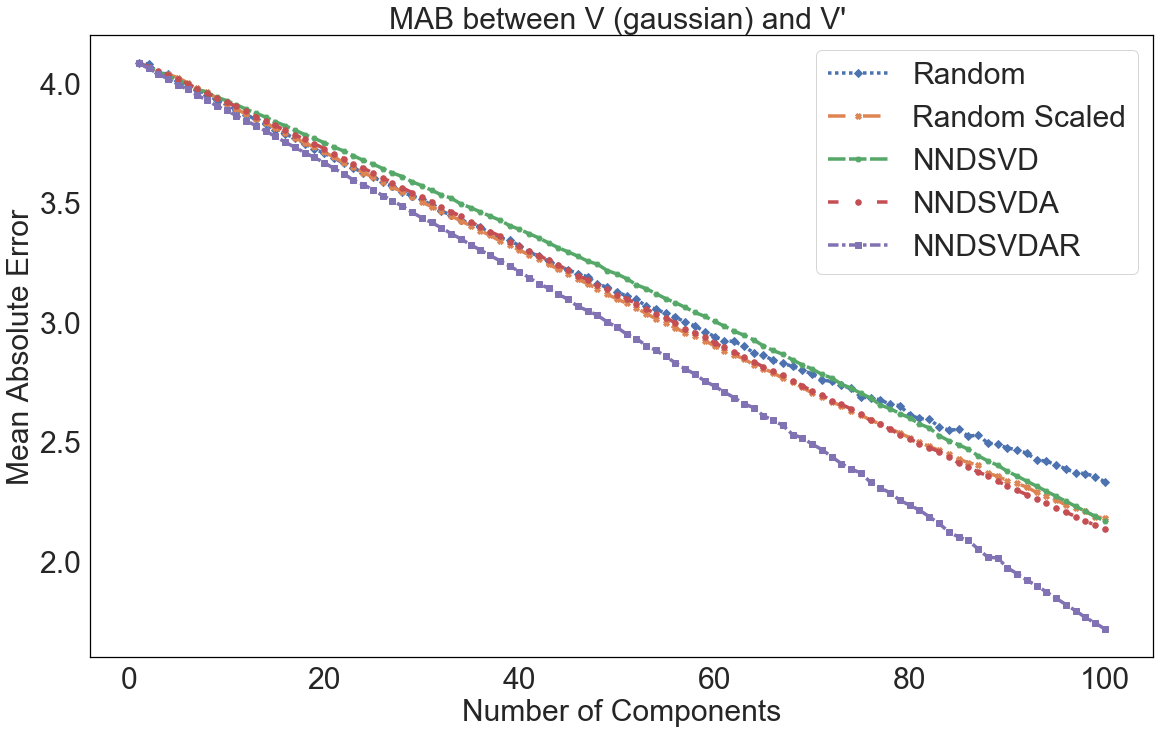

In [170]:
# Plot Mean Absolute Errors
plot_error_graphs_dashed('Mean Absolute Error',  [mab_random,mab_random_scaled,mab_nndsvd,mab_nndsvda,mab_nndsvdar],['Random','Random Scaled','NNDSVD','NNDSVDA','NNDSVDAR'],V.mean(),V.std(),'CheckDifferentInitializationsMAB')

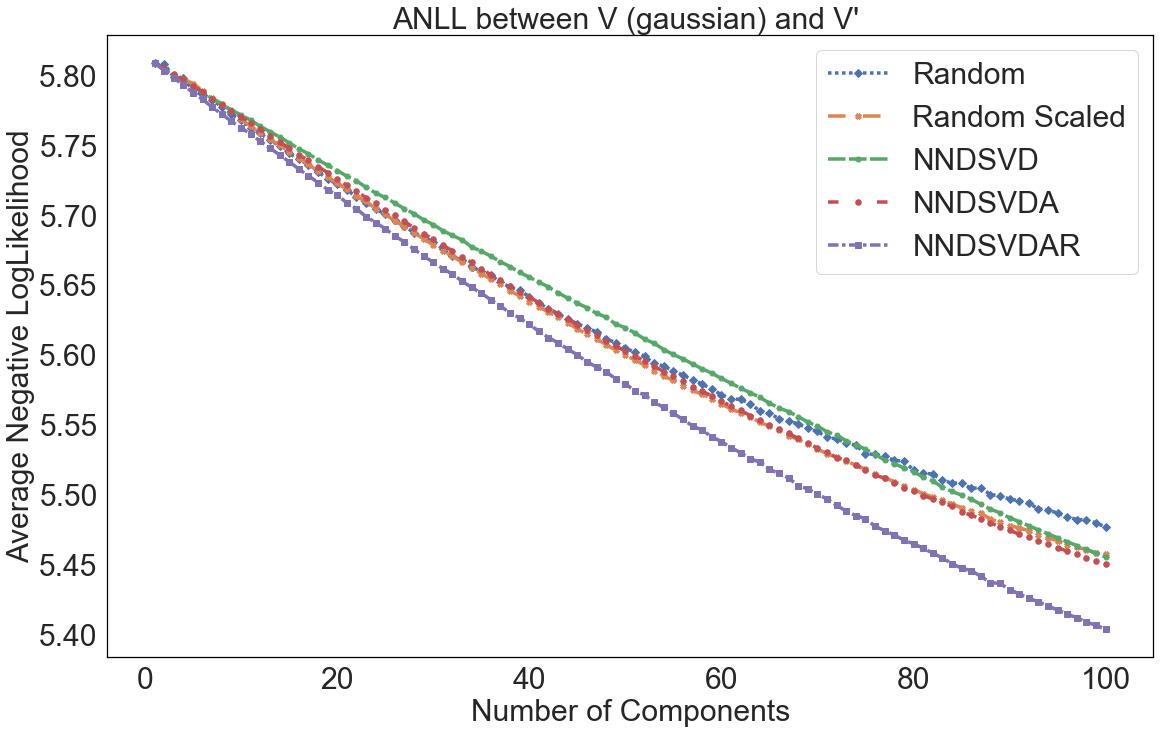

In [175]:
# Plot Mean Absolute Errors
plot_error_graphs_dashed('Average Negative LogLikelihood',  [anl_random,anl_random_scaled,anl_nndsvd,anl_nndsvda,anl_nndsvdar],['Random','Random Scaled','NNDSVD','NNDSVDA','NNDSVDAR'],V.mean(),V.std(),'Check')

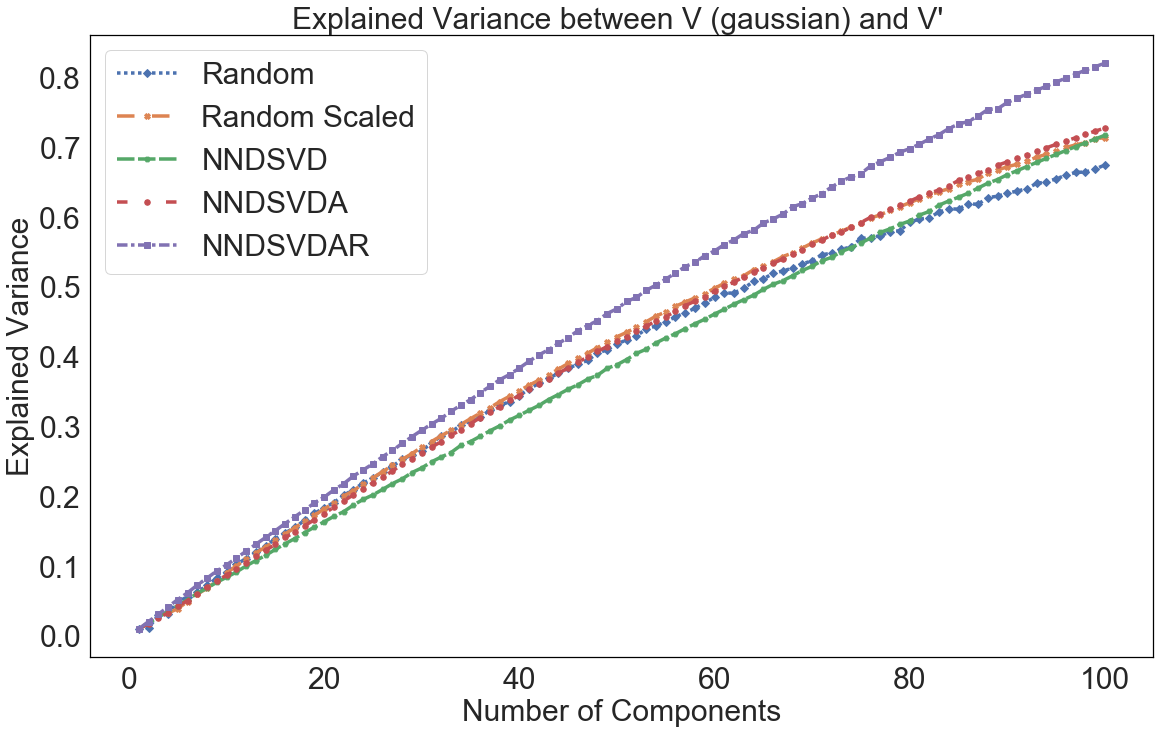

In [181]:
# Explained Variance
plot_error_graphs_dashed('Explained Variance',  [explained_var_ran,explained_var_ran_scale,explained_var_nndsvd,explained_var_nndsvda,explained_var_nndsvdar],['Random','Random Scaled','NNDSVD','NNDSVDA','NNDSVDAR'],V.mean(),V.std(),'')

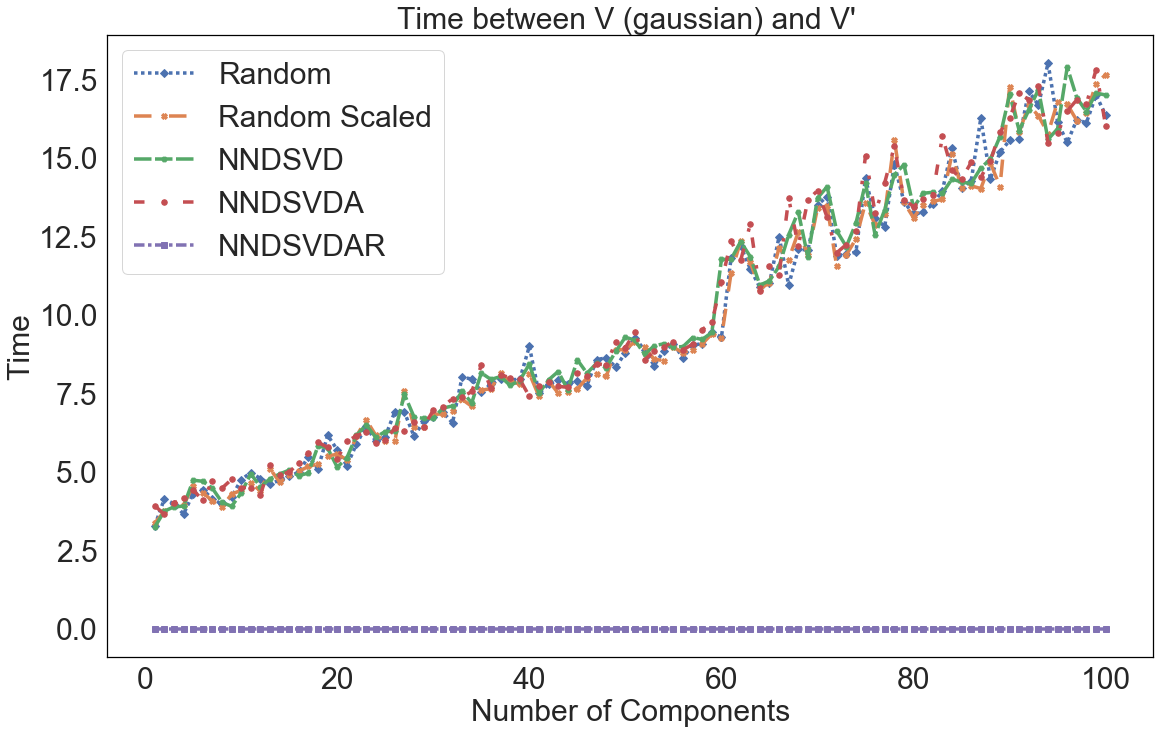

In [183]:
# Explained Variance
plot_error_graphs_dashed('Time',  [time_ran,time_ran_scale,time_nndsvd,time_nndsvda,time_nndsvdar],['Random','Random Scaled','NNDSVD','NNDSVDA','NNDSVDAR'],V.mean(),V.std(),'')

In [41]:
V = normal_positive_data_add_min(rows = 200 , columns = 50, mean=25, std=7)
max_it = 300
start = 1
end = 51

initialization = ['random','random scaled', 'nndsvd', 'nndsvda', 'nndsvdar']
mab_random = np.zeros(50)
mab_random_scaled= np.zeros(50)
mab_nndsvd = np.zeros(50)
mab_nndsvda = np.zeros(50)
mab_nndsvdar = np.zeros(50)

msq_random = np.zeros(50)
msq_random_scaled= np.zeros(50)
msq_nndsvd = np.zeros(50)
msq_nndsvda = np.zeros(50)
msq_nndsvdar = np.zeros(50)
                       
anl_random = np.zeros(50)
anl_random_scaled= np.zeros(50)
anl_nndsvd = np.zeros(50)
anl_nndsvda = np.zeros(50)
anl_nndsvdar = np.zeros(50)


for n in range(start, end):
    print(n)
    rs = RandomState(76321654)
    
        
    #My Random
    rs = RandomState(76321654)
    nmfM = nmfmy(n_components=n,random_state=rs,init=None, distribution='gaussian',max_iterations=max_it)
    Wran, Hran = nmfM.fit_transform(V)
    V_ran = Wran.dot(Hran)
    
    #Scale Random
    rs = RandomState(76321654)
    nmfM = nmfmy(n_components=n,random_state=rs,init='random', distribution='gaussian',max_iterations=max_it)
    Wran_s, Hran_s = nmfM.fit_transform(V)
    V_ran_s = Wran_s.dot(Hran_s)
    
    #NNDSVD
    rs = RandomState(76321654)
    nmfM = nmfmy(n_components=n,random_state=rs,init='nndsvd', distribution='gaussian', max_iterations=max_it)
    Wnndsvd, Hnndsvd = nmfM.fit_transform(V)
    V_nndsvd = Wnndsvd.dot(Hnndsvd)
    
    #NNDSVDA
    rs = RandomState(76321654)
    nmfM = nmfmy(n_components=n,random_state=rs,init='nndsvda', distribution='gaussian', max_iterations=max_it)
    Wnndsvda, Hnndsvda = nmfM.fit_transform(V)
    V_nndsvda = Wnndsvda.dot(Hnndsvda)
    
    #NNDSVDA
    rs = RandomState(76321654)
    nmfM = nmfmy(n_components=n,random_state=rs,init='nndsvdar', distribution='gaussian', max_iterations=max_it)
    Wnndsvdar, Hnndsvdar = nmfM.fit_transform(V)
    V_nndsvdar = Wnndsvdar.dot(Hnndsvdar)

 
    
    # Mean Absolute Value
    mab_random[n-start] = mean_absolute_error(V,V_ran)
    mab_random_scaled[n-start] = mean_absolute_error(V,V_ran_s)
    mab_nndsvd[n-start] = mean_absolute_error(V,V_nndsvd)
    mab_nndsvda[n-start] = mean_absolute_error(V,V_nndsvda)
    mab_nndsvdar[n-start] = mean_absolute_error(V,V_nndsvdar)




    
    # Mean Squared Errors 
    msq_random[n-start] = mean_squared_error(V,V_ran)
    msq_random_scaled[n-start] = mean_squared_error(V,V_ran_s)
    msq_nndsvd[n-start] = mean_squared_error(V,V_nndsvd)
    msq_nndsvda[n-start] = mean_squared_error(V,V_nndsvda)
    msq_nndsvdar[n-start] = mean_squared_error(V,V_nndsvdar)


    # Average Neg Log Likelihoods
  
    diffran = neg_log_likelihood_normal(V, Wran, Hran)
    anl_random[n-start] = diffran / (V.shape[0] * V.shape[1])
    
    diffranscaled = neg_log_likelihood_normal(V, Wran_s, Hran_s)
    anl_random_scaled[n-start] = diffranscaled / (V.shape[0] * V.shape[1])
    
    diffnndsvd = neg_log_likelihood_normal(V, Wnndsvd, Hnndsvd)
    anl_nndsvd[n-start] = diffnndsvd / (V.shape[0] * V.shape[1])

    diffnndsvda = neg_log_likelihood_normal(V, Wnndsvda, Hnndsvda)
    anl_nndsvda[n-start] = diffnndsvda / (V.shape[0] * V.shape[1])

    diffnndsvdar = neg_log_likelihood_normal(V, Wnndsvdar, Hnndsvdar)
    anl_nndsvdar[n-start] = diffnndsvdar / (V.shape[0] * V.shape[1])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [72]:
def plot_fake_graphs(erros_measure,errors,labels,mean,std,title):

   
    formats = ["D","X","H","o","s","^","o","v","2"]
    linestyles = OrderedDict(
    [
     #('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     #('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     #('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     #('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     #('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ])
    
    i = 0
    linestyles_ =  list(linestyles.values())
    
    fig_1 = plt.figure(figsize=(16, 16))
    ax_1 = fig_1.add_subplot(111)
    min_ = min([x.min() for x in errors])
    max_ = max([x.max() for x in errors])

    ax_1.set_ylim([0 ,max_ + 0.8])
    ax_1.set_xlim([0,50])


    
    for (error,label) in zip(errors,labels):
        
        c = i % len(linestyles_)
        ax_1.plot(np.arange(1,error.shape[0]+1), 
                  error+0.8, marker=formats[i],linestyle =linestyles_[c], markersize=5.2,label= label, linewidth=3.20)
        i += 1

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'


    #plt.tight_layout()
    ax_1.set_xlabel('N components')
    ax_1.set_ylabel(erros_measure)
    ax_1.set_title(erros_measure +' for Gaussian Distribution with mean = ' + str("%.3f" % round(mean,3))+ ' and std = ' + str("%.3f" % round(std,3)), fontsize = 30)
    fig_1.tight_layout(pad=0)
    fig_1.savefig('GaussianGraphsDiss/Normal' + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf')



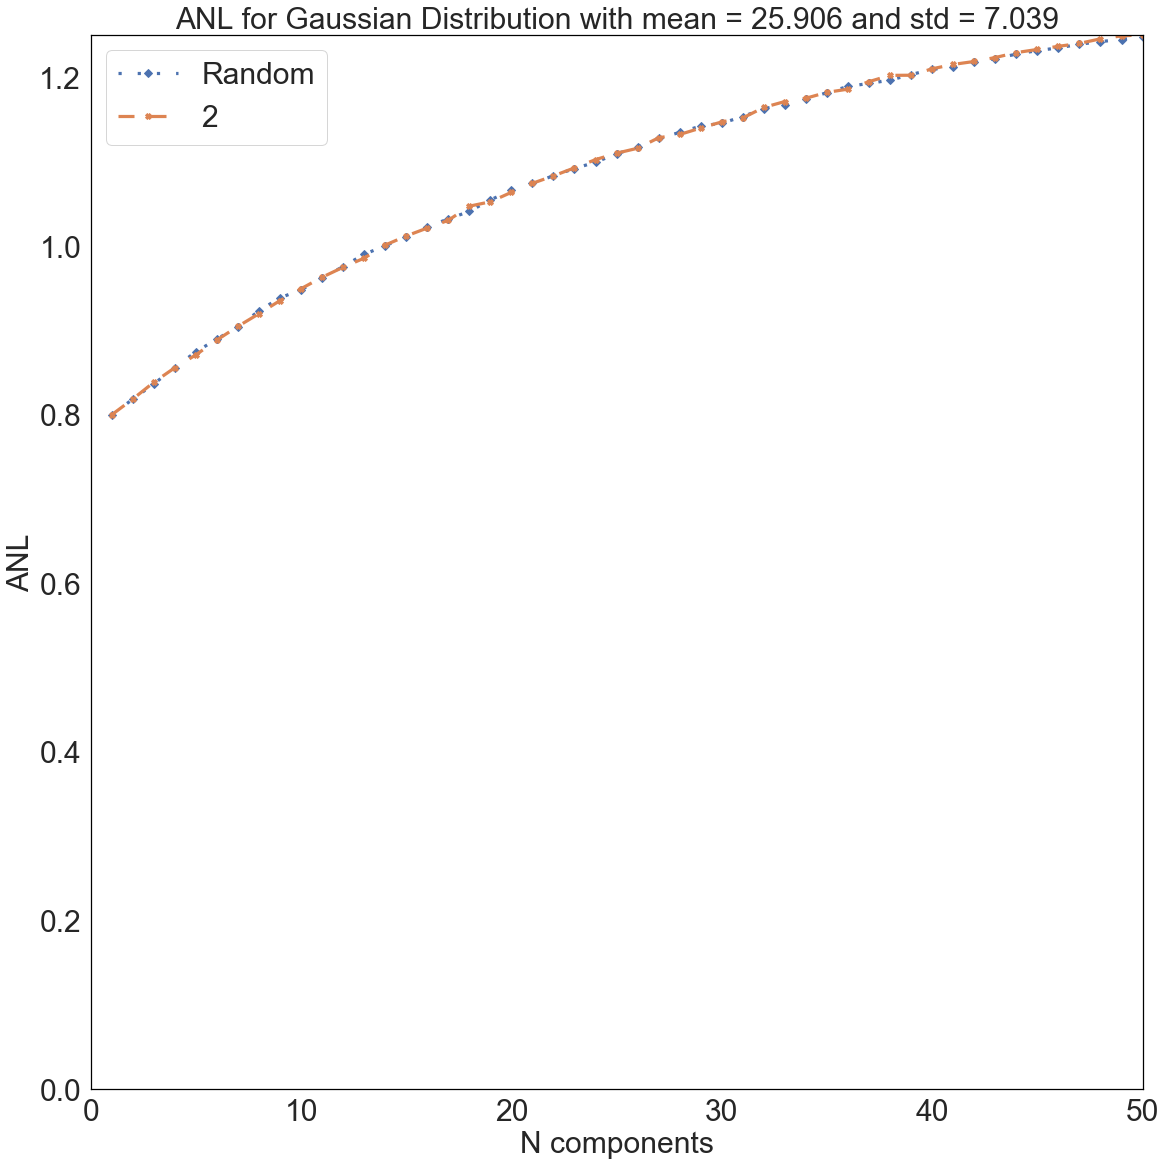

In [75]:
# Plot Mean Absolute Errors
n = anl_random.max() - anl_random
n2 = anl_random_scaled.max() - anl_random_scaled
plot_fake_graphs('ANL',   [n,n2],['Random','2'],V.mean(),V.std(),'CheckDifferentInitializationsANL')
#plot_error_graphs_dashed('ANL',  [anl_random,anl_random_scaled,anl_nndsvd,anl_nndsvda,anl_nndsvdar],['Random','Random Scaled','NNDSVD','NNDSVDA','NNDSVDAR'],V.mean(),V.std(),'CheckDifferentInitializationsANL')

### Iterations

In [117]:
#import matplotlib.ticker as ticker
def plot_it_graphs(erros_measure,errors,labels,max_it,mean,std,title):

    fig_1 = plt.figure(figsize=(16, 16))
    ax_1 = fig_1.add_subplot(111)

    
    for (error,label) in zip(errors,labels):
    
        ax_1.plot(np.arange(0,max_it), 
                  error,linestyle='--',  label= label, linewidth=3.10)
        

    for item in ([ax_1.title, ax_1.xaxis.label, ax_1.yaxis.label] +
                 ax_1.get_xticklabels() + ax_1.get_yticklabels()):
        item.set_fontsize(30)
    
    ax_1.legend(loc=0, fontsize = 30)
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['axes.edgecolor'] = 'black'
    #ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.log(x)/np.log(15)))
    #ax_1.xaxis.set_major_formatter(ticks_x)
    #ax_1.xaxis.set_ticks([0,10,50,100,200,300,400])

    #plt.tight_layout()
    ax_1.set_xlabel('Iteration')
    ax_1.set_ylabel('Average Negative Log Likelihood')
    ax_1.set_title(erros_measure +' for Gaussian Distribution with mean = ' + str("%.3f" % round(mean,3))+ ' and std = ' + str("%.3f" % round(std,3)), fontsize = 30)
    fig_1.tight_layout(pad=0)
    fig_1.savefig('InitGraphs/NormalIterations' + title + 'mean=' + str("%.3f" % round(mean,3))+ 'std=' + str("%.3f" % round(std,3)) +'.pdf')


In [76]:
V = normal_positive_data_add_min(rows = 10000 , columns = 500, mean=3, std=1.35)
max_it = 1000
start = 1
end = 51
n = 25

initialization = ['random','random scaled', 'nndsvd', 'nndsvda', 'nndsvdar']
mab_random = np.zeros(max_it)
mab_random_scaled= np.zeros(max_it)
mab_nndsvd = np.zeros(max_it)
mab_nndsvda = np.zeros(max_it)
mab_nndsvdar = np.zeros(max_it)

msq_random = np.zeros(max_it)
msq_random_scaled= np.zeros(max_it)
msq_nndsvd = np.zeros(max_it)
msq_nndsvda = np.zeros(max_it)
msq_nndsvdar = np.zeros(max_it)
                       
anl_random = np.zeros(max_it)
anl_random_scaled= np.zeros(max_it)
anl_nndsvd = np.zeros(max_it)
anl_nndsvda = np.zeros(max_it)
anl_nndsvdar = np.zeros(max_it)

#My Random
rs = RandomState(76321654)
nmfM1 = nmfmy(n_components=n,random_state=rs,init=None, distribution='gaussian',max_iterations=0)
nmfM1.fit(V)
Wran, Hran = nmfM1.get_components()
V_ran = Wran.dot(Hran)
print(Wran.shape)
print(Hran.shape)


#Scale Random
rs = RandomState(76321654)
nmfM2 = nmfmy(n_components=n,random_state=rs,init='random', distribution='gaussian',max_iterations=0)
nmfM2.fit(V)
Wran_s, Hran_s = nmfM2.get_components()
V_ran_s = Wran_s.dot(Hran_s)

#NNDSVD
rs = RandomState(76321654)
nmfM3 = nmfmy(n_components=n,random_state=rs,init='nndsvd', distribution='gaussian', max_iterations=0)
nmfM3.fit(V)
Wnndsvd, Hnndsvd = nmfM3.get_components()
V_nndsvd = Wnndsvd.dot(Hnndsvd)
    
#NNDSVDA
rs = RandomState(76321654)
nmfM4 = nmfmy(n_components=n,random_state=rs,init='nndsvda', distribution='gaussian', max_iterations=0)
nmfM4.fit(V)
Wnndsvda, Hnndsvda = nmfM4.get_components()
V_nndsvda = Wnndsvda.dot(Hnndsvda)
    
#NNDSVDA
rs = RandomState(76321654)
nmfM5 = nmfmy(n_components=n,random_state=rs,init='nndsvdar', distribution='gaussian', max_iterations=0)
nmfM5.fit(V)
Wnndsvdar, Hnndsvdar = nmfM5.get_components()
V_nndsvdar = Wnndsvdar.dot(Hnndsvdar)

'''
# Mean Absolute Value
mab_random[0] = mean_absolute_error(V,V_ran)
mab_random_scaled[0] = mean_absolute_error(V,V_ran_s)
mab_nndsvd[0] = mean_absolute_error(V,V_nndsvd)
mab_nndsvda[0] = mean_absolute_error(V,V_nndsvda)
mab_nndsvdar[0] = mean_absolute_error(V,V_nndsvdar)
  
# Mean Squared Errors 
msq_random[0] = mean_squared_error(V,V_ran)
msq_random_scaled[0] = mean_squared_error(V,V_ran_s)
msq_nndsvd[0] = mean_squared_error(V,V_nndsvd)
msq_nndsvda[0] = mean_squared_error(V,V_nndsvda)
msq_nndsvdar[0] = mean_squared_error(V,V_nndsvdar)


# Average Neg Log Likelihoods
  
diffran = neg_log_likelihood_normal(V, Wran, Hran)
anl_random[0] = diffran / (V.shape[0] * V.shape[1])

diffranscaled = neg_log_likelihood_normal(V, Wran_s, Hran_s)
anl_random_scaled[0] = diffranscaled / (V.shape[0] * V.shape[1])
    
diffnndsvd = neg_log_likelihood_normal(V, Wnndsvd, Hnndsvd)
anl_nndsvd[0] = diffnndsvd / (V.shape[0] * V.shape[1])

diffnndsvda = neg_log_likelihood_normal(V, Wnndsvda, Hnndsvda)
anl_nndsvda[0] = diffnndsvda / (V.shape[0] * V.shape[1])

diffnndsvdar = neg_log_likelihood_normal(V, Wnndsvdar, Hnndsvdar)
anl_nndsvdar[0] = diffnndsvdar / (V.shape[0] * V.shape[1])
'''
for i in range(0, max_it):
    print(i)
    
        
    
    # Random 
    
    Wran, Hran = nmfM1.transform(V,1)
    V_ran = Wran.dot(Hran)
    
    #Scale Random
   
    Wran_s, Hran_s = nmfM2.transform(V,1)
    V_ran_s = Wran_s.dot(Hran_s)
    
    #NNDSVD
    
    Wnndsvd, Hnndsvd = nmfM3.transform(V,1)
    V_nndsvd = Wnndsvd.dot(Hnndsvd)
    
    #NNDSVDA
   
    Wnndsvda, Hnndsvda = nmfM4.transform(V,1)
    V_nndsvda = Wnndsvda.dot(Hnndsvda)
    
    #NNDSVDA
   
    Wnndsvdar, Hnndsvdar = nmfM5.transform(V,1)
    V_nndsvdar = Wnndsvdar.dot(Hnndsvdar)

 
    
    # Mean Absolute Value
    mab_random[i] = mean_absolute_error(V,V_ran)
    mab_random_scaled[i] = mean_absolute_error(V,V_ran_s)
    mab_nndsvd[i] = mean_absolute_error(V,V_nndsvd)
    mab_nndsvda[i] = mean_absolute_error(V,V_nndsvda)
    mab_nndsvdar[i] = mean_absolute_error(V,V_nndsvdar)



    
    # Mean Squared Errors 
    msq_random[i] = mean_squared_error(V,V_ran)
    msq_random_scaled[i] = mean_squared_error(V,V_ran_s)
    msq_nndsvd[i] = mean_squared_error(V,V_nndsvd)
    msq_nndsvda[i] = mean_squared_error(V,V_nndsvda)
    msq_nndsvdar[i] = mean_squared_error(V,V_nndsvdar)


    # Average Neg Log Likelihoods
  
    diffran = neg_log_likelihood_normal(V, Wran, Hran)
    anl_random[i] = neg_log_likelihood_normal(V, Wran, Hran)
    
    diffranscaled = neg_log_likelihood_normal(V, Wran_s, Hran_s)
    anl_random_scaled[i] = neg_log_likelihood_normal(V, Wran_s, Hran_s)
    
    diffnndsvd = neg_log_likelihood_normal(V, Wnndsvd, Hnndsvd)
    anl_nndsvd[i] = neg_log_likelihood_normal(V, Wnndsvd, Hnndsvd)

    diffnndsvda = neg_log_likelihood_normal(V, Wnndsvda, Hnndsvda)
    anl_nndsvda[i] = neg_log_likelihood_normal(V, Wnndsvda, Hnndsvda)

    diffnndsvdar = neg_log_likelihood_normal(V, Wnndsvdar, Hnndsvdar)
    anl_nndsvdar[i] = neg_log_likelihood_normal(V, Wnndsvdar, Hnndsvdar)

(10000, 25)
(25, 500)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


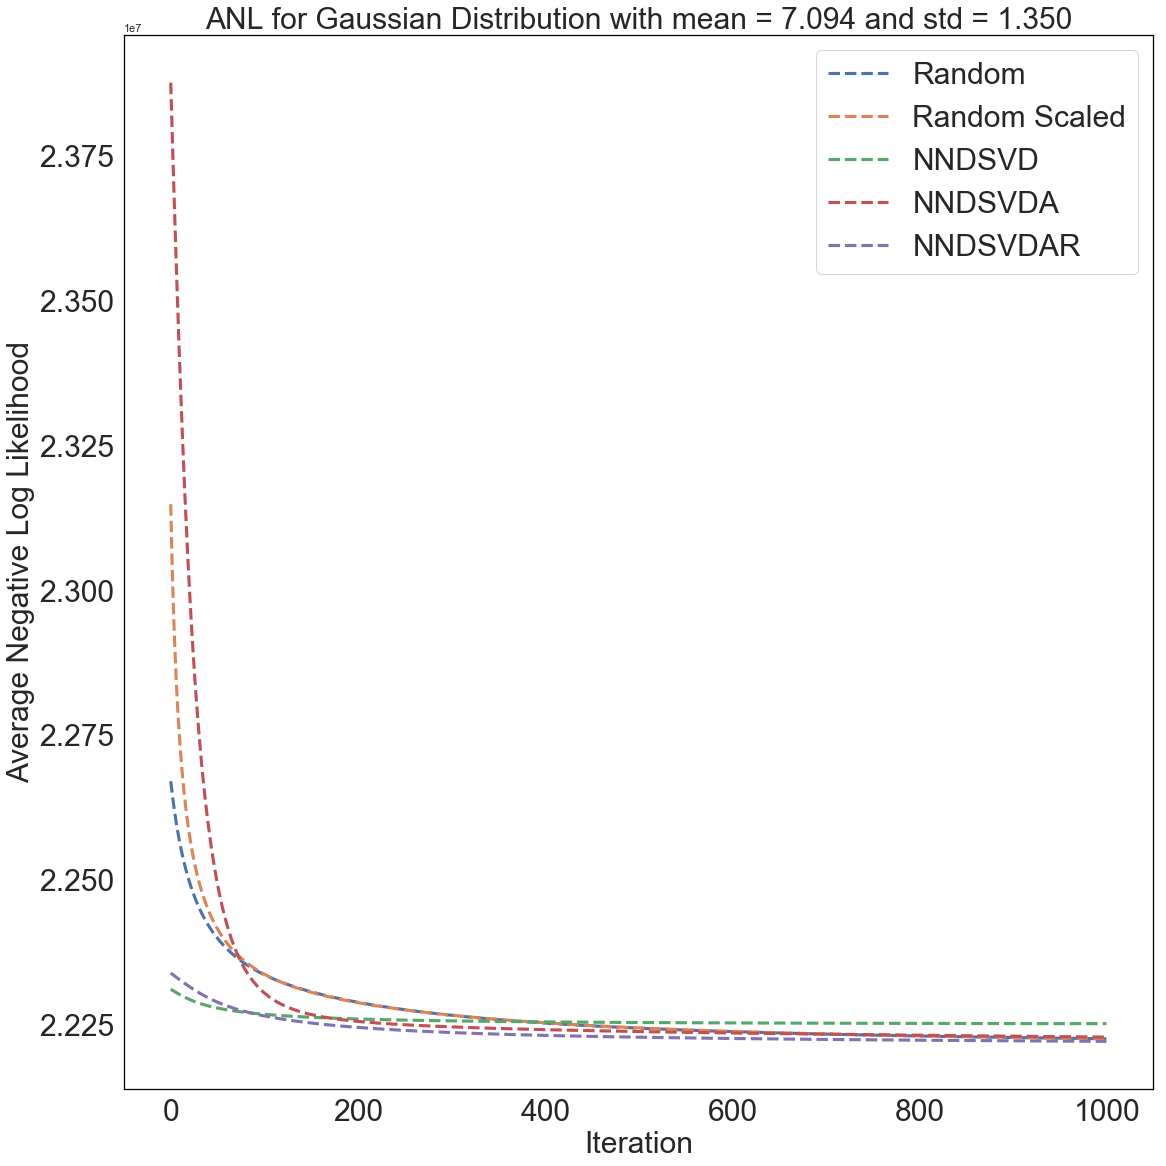

In [119]:
# Plot Mean Absolute Errors
plot_it_graphs('ANL',  [anl_random,anl_random_scaled,anl_nndsvd,anl_nndsvda,anl_nndsvdar],['Random','Random Scaled','NNDSVD','NNDSVDA','NNDSVDAR'],max_it,V.mean(),V.std(),'CheckDifferentInitializationsANL')

In [154]:
V = normal_positive_data_add_min(rows = 500 , columns = 100, mean=3, std=3.315)
max_it = 400
start = 1
end = 101

initialization = ['random','random scaled', 'nndsvd', 'nndsvda', 'nndsvdar']
mab_random = np.zeros(end)
mab_random_scaled= np.zeros(end)
mab_nndsvd = np.zeros(end)
mab_nndsvda = np.zeros(end)
mab_nndsvdar = np.zeros(end)

msq_random = np.zeros(end)
msq_random_scaled= np.zeros(end)
msq_nndsvd = np.zeros(end)
msq_nndsvda = np.zeros(end)
msq_nndsvdar = np.zeros(end)
                       
anl_random = np.zeros(end)
anl_random_scaled= np.zeros(end)
anl_nndsvd = np.zeros(end)
anl_nndsvda = np.zeros(end)
anl_nndsvdar = np.zeros(end)



'''
# Mean Absolute Value
mab_random[0] = mean_absolute_error(V,V_ran)
mab_random_scaled[0] = mean_absolute_error(V,V_ran_s)
mab_nndsvd[0] = mean_absolute_error(V,V_nndsvd)
mab_nndsvda[0] = mean_absolute_error(V,V_nndsvda)
mab_nndsvdar[0] = mean_absolute_error(V,V_nndsvdar)
  
# Mean Squared Errors 
msq_random[0] = mean_squared_error(V,V_ran)
msq_random_scaled[0] = mean_squared_error(V,V_ran_s)
msq_nndsvd[0] = mean_squared_error(V,V_nndsvd)
msq_nndsvda[0] = mean_squared_error(V,V_nndsvda)
msq_nndsvdar[0] = mean_squared_error(V,V_nndsvdar)


# Average Neg Log Likelihoods
  
diffran = neg_log_likelihood_normal(V, Wran, Hran)
anl_random[0] = diffran / (V.shape[0] * V.shape[1])

diffranscaled = neg_log_likelihood_normal(V, Wran_s, Hran_s)
anl_random_scaled[0] = diffranscaled / (V.shape[0] * V.shape[1])
    
diffnndsvd = neg_log_likelihood_normal(V, Wnndsvd, Hnndsvd)
anl_nndsvd[0] = diffnndsvd / (V.shape[0] * V.shape[1])

diffnndsvda = neg_log_likelihood_normal(V, Wnndsvda, Hnndsvda)
anl_nndsvda[0] = diffnndsvda / (V.shape[0] * V.shape[1])

diffnndsvdar = neg_log_likelihood_normal(V, Wnndsvdar, Hnndsvdar)
anl_nndsvdar[0] = diffnndsvdar / (V.shape[0] * V.shape[1])
'''
for n in range(start, end):
    print(n)
    
    #My Random
    rs = RandomState(76321654)
    nmfM1 = nmfmy(n_components=n,random_state=rs,init=None, distribution='gaussian',max_iterations=max_it)
    Wran, Hran = nmfM1.fit_transform(V)
    V_ran = Wran.dot(Hran)
    print(Wran.shape)
    print(Hran.shape)
        
    
    #Scale Random
    rs = RandomState(76321654)
    nmfM2 = nmfmy(n_components=n,random_state=rs,init='random', distribution='gaussian',max_iterations=max_it)
    Wran_s, Hran_s = nmfM2.fit_transform(V)
    V_ran_s = Wran_s.dot(Hran_s)

    #NNDSVD
    rs = RandomState(76321654)
    nmfM3 = nmfmy(n_components=n,random_state=rs,init='nndsvd', distribution='gaussian', max_iterations=max_it)
    Wnndsvd, Hnndsvd = nmfM3.fit_transform(V)
    V_nndsvd = Wnndsvd.dot(Hnndsvd)
    
    #NNDSVDA
    rs = RandomState(76321654)
    nmfM4 = nmfmy(n_components=n,random_state=rs,init='nndsvda', distribution='gaussian', max_iterations=max_it)
    Wnndsvda, Hnndsvda = nmfM4.fit_transform(V)
    V_nndsvda = Wnndsvda.dot(Hnndsvda)
    
    #NNDSVDA
    rs = RandomState(76321654)
    nmfM5 = nmfmy(n_components=n,random_state=rs,init='nndsvdar', distribution='gaussian', max_iterations=max_it)
    Wnndsvdar, Hnndsvdar = nmfM5.fit_transform(V)
    V_nndsvdar = Wnndsvdar.dot(Hnndsvdar)

 
    i = n - start
    # Mean Absolute Value
    mab_random[i] = mean_absolute_error(V,V_ran)
    mab_random_scaled[i] = mean_absolute_error(V,V_ran_s)
    mab_nndsvd[i] = mean_absolute_error(V,V_nndsvd)
    mab_nndsvda[i] = mean_absolute_error(V,V_nndsvda)
    mab_nndsvdar[i] = mean_absolute_error(V,V_nndsvdar)



    
    # Mean Squared Errors 
    msq_random[i] = mean_squared_error(V,V_ran)
    msq_random_scaled[i] = mean_squared_error(V,V_ran_s)
    msq_nndsvd[i] = mean_squared_error(V,V_nndsvd)
    msq_nndsvda[i] = mean_squared_error(V,V_nndsvda)
    msq_nndsvdar[i] = mean_squared_error(V,V_nndsvdar)


    # Average Neg Log Likelihoods
  
    diffran = neg_log_likelihood_normal(V, Wran, Hran)
    anl_random[i] = diffran / (V.shape[0] * V.shape[1])
    
    diffranscaled = neg_log_likelihood_normal(V, Wran_s, Hran_s)
    anl_random_scaled[i] = diffranscaled / (V.shape[0] * V.shape[1])
    
    diffnndsvd = neg_log_likelihood_normal(V, Wnndsvd, Hnndsvd)
    anl_nndsvd[i] = diffnndsvd / (V.shape[0] * V.shape[1])

    diffnndsvda = neg_log_likelihood_normal(V, Wnndsvda, Hnndsvda)
    anl_nndsvda[i] = diffnndsvda / (V.shape[0] * V.shape[1])

    diffnndsvdar = neg_log_likelihood_normal(V, Wnndsvdar, Hnndsvdar)
    anl_nndsvdar[i] = diffnndsvdar / (V.shape[0] * V.shape[1])

1
(500, 1)
(1, 100)
2
(500, 2)
(2, 100)
3
(500, 3)
(3, 100)
4
(500, 4)
(4, 100)
5
(500, 5)
(5, 100)
6
(500, 6)
(6, 100)
7
(500, 7)
(7, 100)
8
(500, 8)
(8, 100)
9
(500, 9)
(9, 100)
10
(500, 10)
(10, 100)
11
(500, 11)
(11, 100)
12
(500, 12)
(12, 100)
13
(500, 13)
(13, 100)
14
(500, 14)
(14, 100)
15
(500, 15)
(15, 100)
16
(500, 16)
(16, 100)
17
(500, 17)
(17, 100)
18
(500, 18)
(18, 100)
19
(500, 19)
(19, 100)
20
(500, 20)
(20, 100)
21
(500, 21)
(21, 100)
22
(500, 22)
(22, 100)
23
(500, 23)
(23, 100)
24
(500, 24)
(24, 100)
25
(500, 25)
(25, 100)
26
(500, 26)
(26, 100)
27
(500, 27)
(27, 100)
28
(500, 28)
(28, 100)
29
(500, 29)
(29, 100)
30
(500, 30)
(30, 100)
31
(500, 31)
(31, 100)
32
(500, 32)
(32, 100)
33
(500, 33)
(33, 100)
34
(500, 34)
(34, 100)
35
(500, 35)
(35, 100)
36
(500, 36)
(36, 100)
37
(500, 37)
(37, 100)
38
(500, 38)
(38, 100)
39
(500, 39)
(39, 100)
40
(500, 40)
(40, 100)
41
(500, 41)
(41, 100)
42
(500, 42)
(42, 100)
43
(500, 43)
(43, 100)
44
(500, 44)
(44, 100)
45
(500, 45)
(4

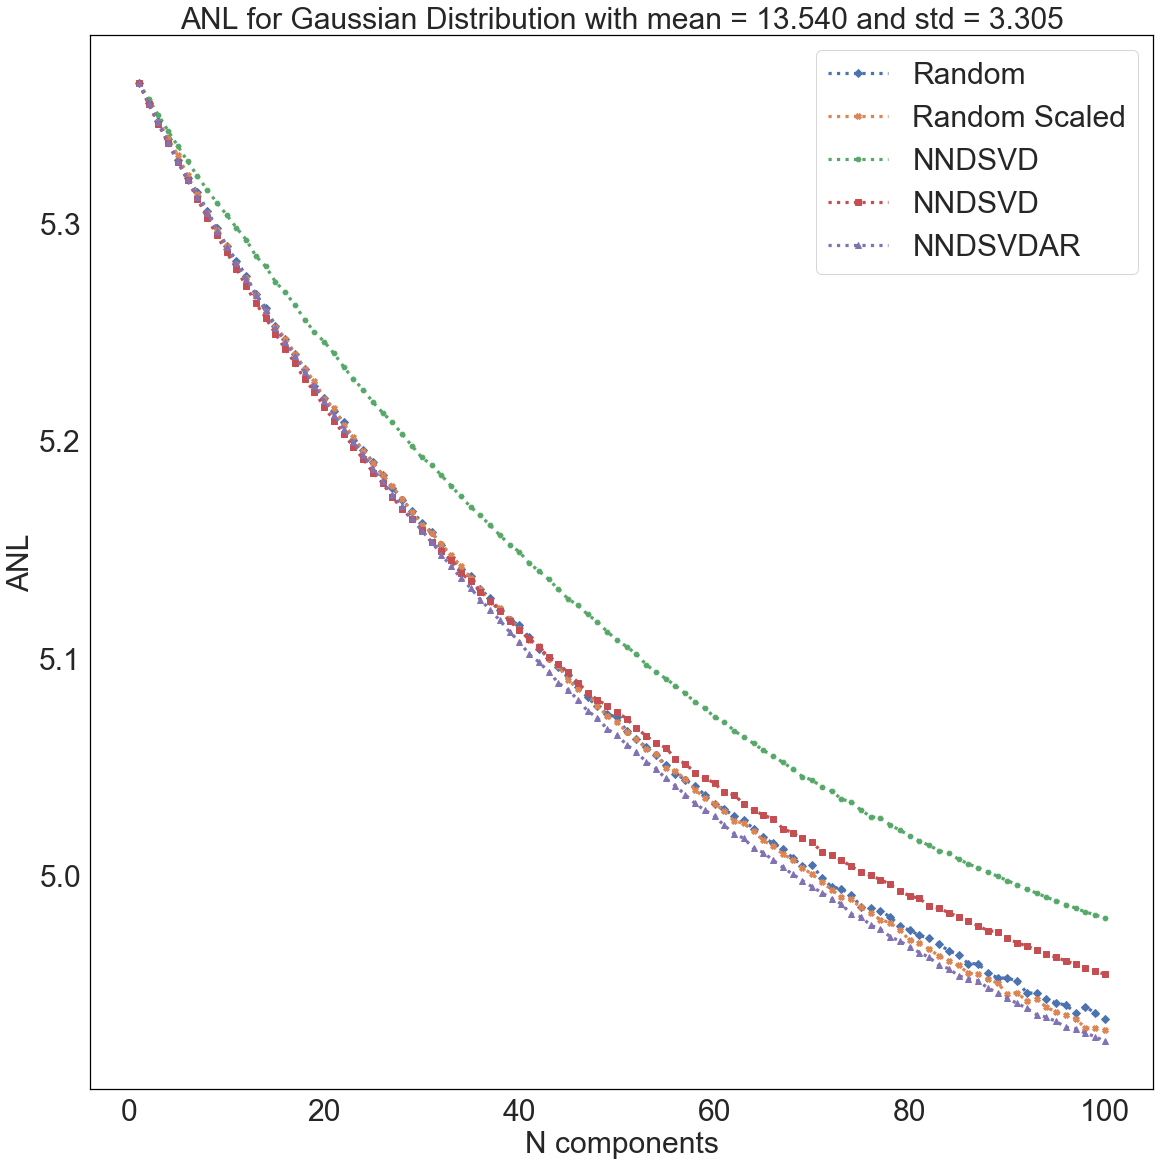

In [194]:
# Plot Mean Absolute Errors
plot_error_graphs_dotted('ANL',  [anl_random[:-1],anl_random_scaled[:-1],anl_nndsvd[:-1],anl_nndsvda[:-1],anl_nndsvdar[:-1]],['Random','Random Scaled','NNDSVD','NNDSVD','NNDSVDAR'],V.mean(),V.std(),'CheckDifferentInitializationsANL')

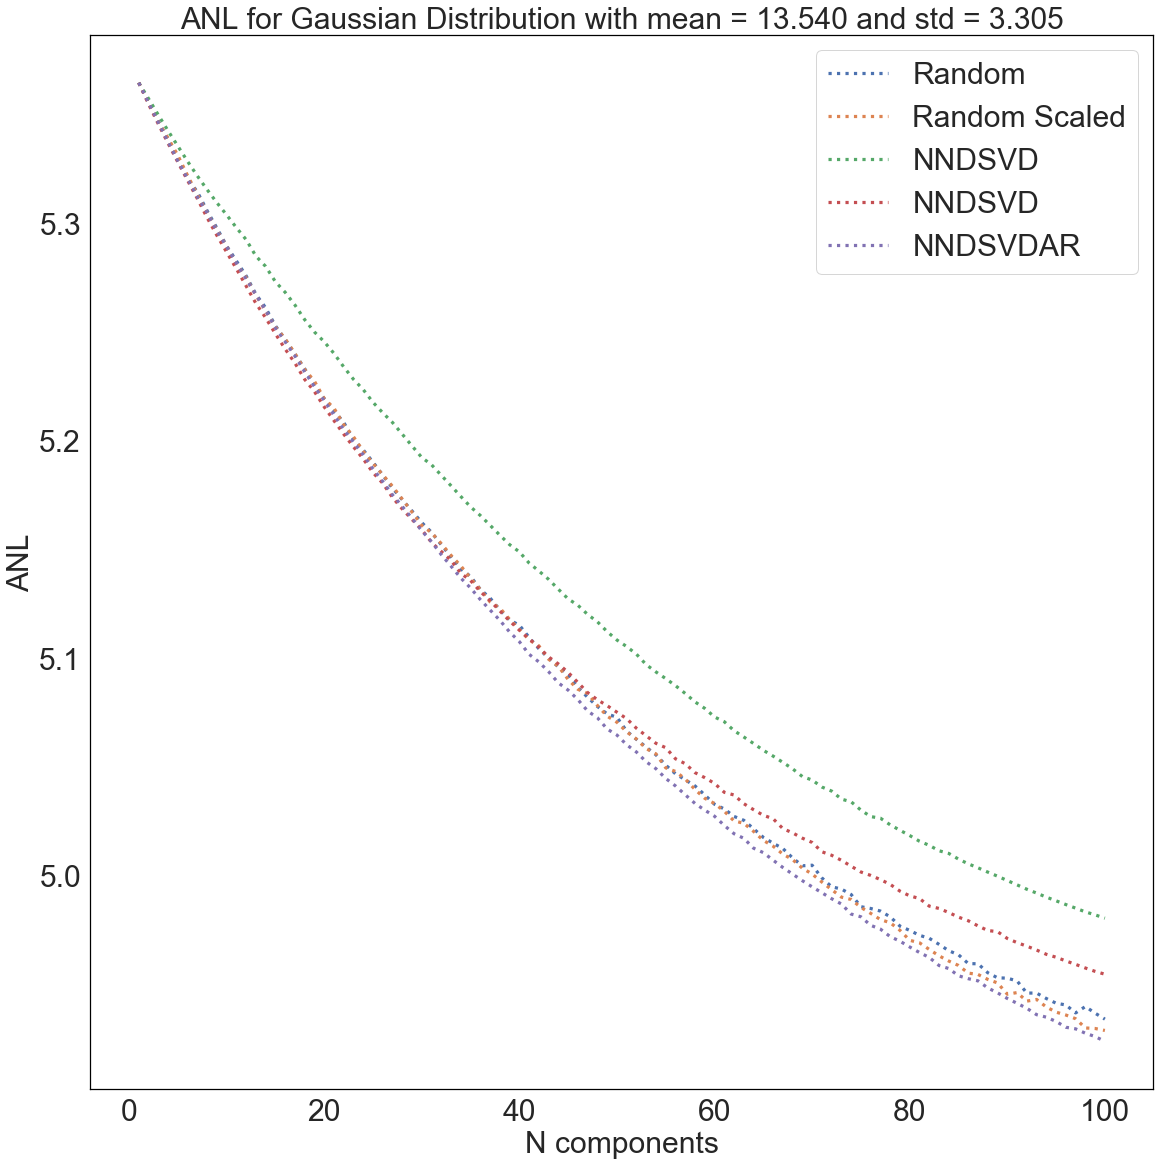

In [195]:
plot_error_graphs_dotted_no_mark('ANL',  [anl_random[:-1],anl_random_scaled[:-1],anl_nndsvd[:-1],anl_nndsvda[:-1],anl_nndsvdar[:-1]],['Random','Random Scaled','NNDSVD','NNDSVD','NNDSVDAR'],V.mean(),V.std(),'CheckDifferentInitializationsANL')

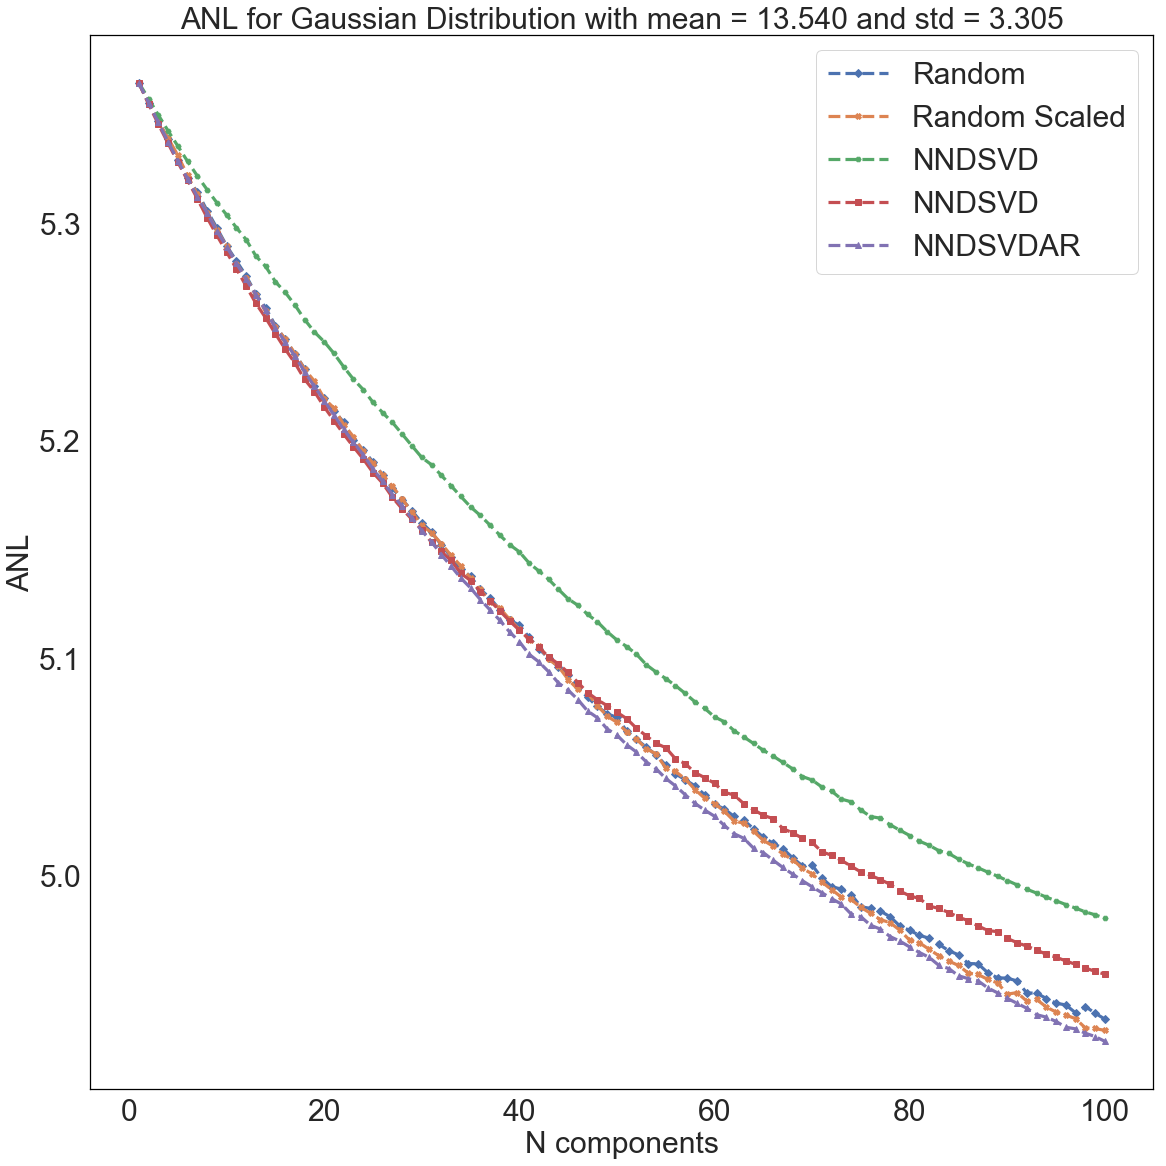

In [196]:
# Plot Mean Absolute Errors
plot_error_graphs_dashed('ANL',  [anl_random[:-1],anl_random_scaled[:-1],anl_nndsvd[:-1],anl_nndsvda[:-1],anl_nndsvdar[:-1]],['Random','Random Scaled','NNDSVD','NNDSVD','NNDSVDAR'],V.mean(),V.std(),'CheckDifferentInitializationsANL')

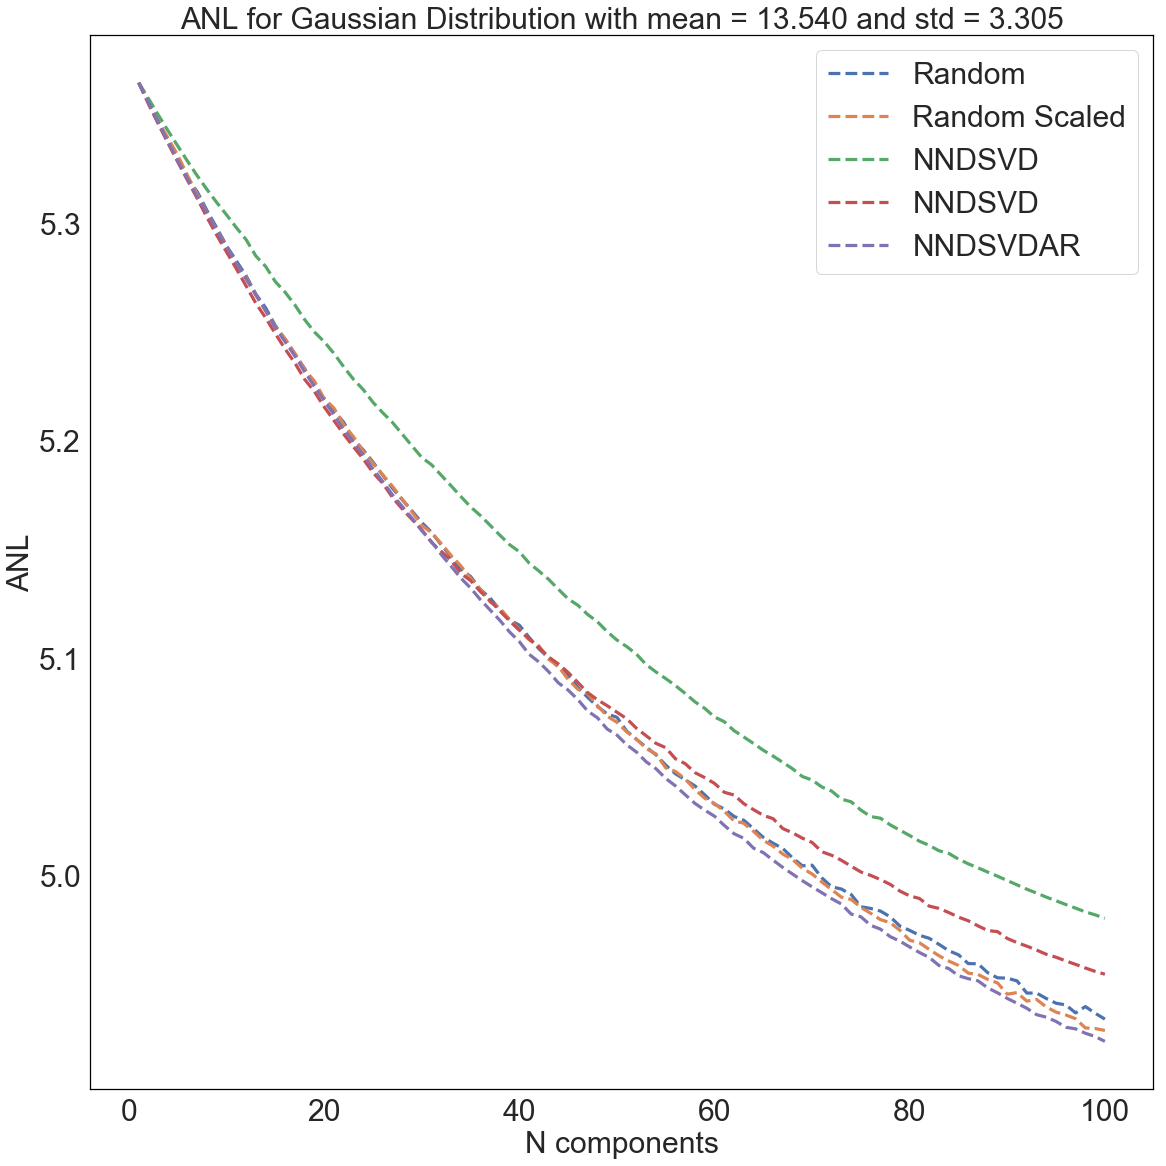

In [197]:
# Plot Mean Absolute Errors
plot_error_graphs_no_marker('ANL',  [anl_random[:-1],anl_random_scaled[:-1],anl_nndsvd[:-1],anl_nndsvda[:-1],anl_nndsvdar[:-1]],['Random','Random Scaled','NNDSVD','NNDSVD','NNDSVDAR'],V.mean(),V.std(),'CheckDifferentInitializationsANL')